In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from datasets import Dataset

from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score
import torch.nn.functional as F

import io
import os
import re

from transformers import pipeline


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Chargement des données

In [38]:
df = pd.read_csv('data/spam_v2.csv')
df.head()

,texte,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni... nan nan nan,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



📊 Rapport de classification : Evaluation
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99      4825
        Spam       0.97      0.91      0.94       747

    accuracy                           0.98      5572
   macro avg       0.98      0.95      0.96      5572
weighted avg       0.98      0.98      0.98      5572

AUC ROC : 0.951


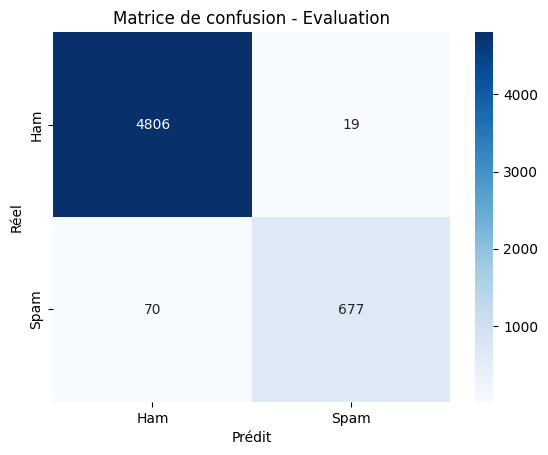

In [39]:
classifier = pipeline("text-classification", model="mrm8488/bert-tiny-finetuned-sms-spam-detection")

texts_raw = df["texte"].tolist()
predictions_raw = classifier(texts_raw, truncation=True, padding=True)
df["pred_raw"] = [1 if p["label"].lower() in ["spam", "label_1"] else 0 for p in predictions_raw]

def evaluate(true, pred, title):
    cm = confusion_matrix(true, pred)
    f1 = roc_auc_score(true, pred)
    print(f"\n📊 Rapport de classification : {title}")
    print(classification_report(true, pred, target_names=["Ham", "Spam"]))
    print(f"AUC ROC : {f1:.3f}")

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f"Matrice de confusion - {title}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()

# Comparaison visuelle
evaluate(df["target"], df["pred_raw"], "Evaluation")


In [40]:
train_df, test_df = train_test_split(df, test_size=0.2)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [41]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["texte"], padding="max_length", truncation=True, max_length=128)


train_dataset = train_dataset.map(tokenize, batched=True, batch_size=None)
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=None)

# Ajout des labels
train_dataset = train_dataset.add_column("labels", train_df["target"].tolist())
test_dataset = test_dataset.add_column("labels", test_df["target"].tolist())

# Vérifie que les colonnes sont présentes
print(train_dataset[0])  # Doit afficher 'input_ids', 'attention_mask', et 'labels'


Map: 100%|██████████| 1115/1115 [00:00<00:00, 8170.72 examples/s]

{'texte': "No I'm in the same boat. Still here at my moms. Check me out on yo. I'm half naked. nan nan nan", 'target': 0, 'pred_raw': 0, '__index_level_0__': 1978, 'input_ids': [101, 2053, 1045, 1005, 1049, 1999, 1996, 2168, 4049, 1012, 2145, 2182, 2012, 2026, 3566, 2015, 1012, 4638, 2033, 2041, 2006, 10930, 1012, 1045, 1005, 1049, 2431, 6248, 1012, 16660, 16660, 16660, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [42]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    num_train_epochs=4,
    eval_strategy ="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.080400,0.035399,0.994619
2,0.021500,0.037236,0.993722
3,0.009400,0.038329,0.993722
4,0.006000,0.040893,0.994619


TrainOutput(global_step=2232, training_loss=0.026632822943203766, metrics={'train_runtime': 973.2869, 'train_samples_per_second': 18.317, 'train_steps_per_second': 2.293, 'total_flos': 590407195809792.0, 'train_loss': 0.026632822943203766, 'epoch': 4.0})

In [44]:
# Récupère les prédictions et les labels
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
labels = test_dataset["labels"]

# Calcule l'accuracy
accuracy = accuracy_score(labels, preds)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9946


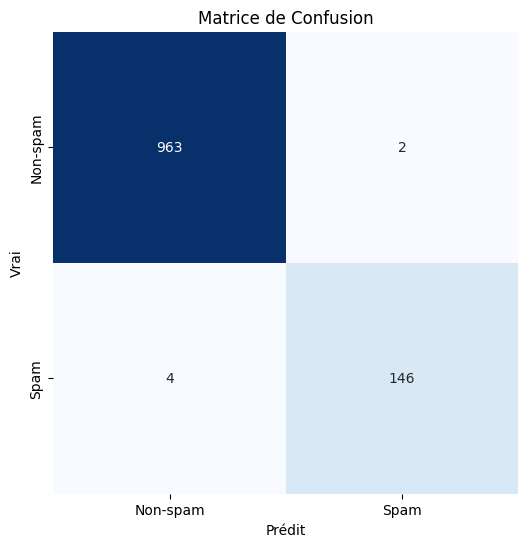

In [45]:
# Matrice de confusion
cm = confusion_matrix(labels, preds)

# Affichage
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-spam", "Spam"],
            yticklabels=["Non-spam", "Spam"])
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de Confusion")
plt.show()


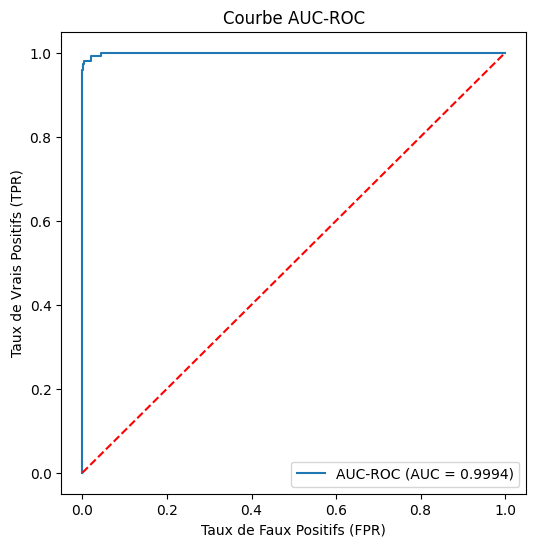

In [46]:
# Probabilités pour la classe positive (spam)
probabilities = predictions.predictions[:, 1]
auc_roc = roc_auc_score(labels, probabilities)

# Courbe ROC
fpr, tpr, thresholds = roc_curve(labels, probabilities)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC-ROC (AUC = {auc_roc:.4f})")
plt.plot([0, 1], [0, 1], "r--")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe AUC-ROC")
plt.legend()
plt.show()


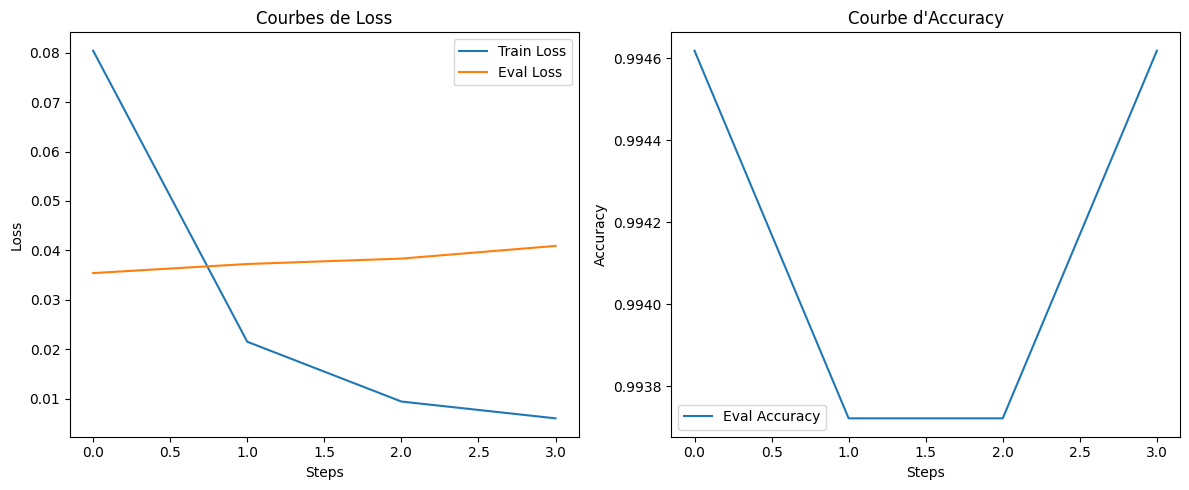

In [47]:
# Récupère les logs d'entraînement
history = trainer.state.log_history

# Filtre les logs pour extraire les métriques
train_loss = [log["loss"] for log in history if "loss" in log]
eval_loss = [log["eval_loss"] for log in history if "eval_loss" in log]
eval_accuracy = [log["eval_accuracy"] for log in history if "eval_accuracy" in log]

# Courbe de loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Courbes de Loss")
plt.legend()

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_accuracy, label="Eval Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Courbe d'Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
